<h2>Overview</h2>

There are quite a few discussions about the best validation method in LANL competition. The main argument against KFold (shuffle) is that segments from the same earthquake in train and validation sets could leak information about the later. This doesn't happen in the test set, since earthquakes are totally different from the training data.

To check this argument, I am trying to predict which earthquake a segment came from. I am not sure if this is the correct approach, so let me know your ideas about this experiment.

In [1]:
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
# seaborn and matplot
import matplotlib.pyplot as plt
import seaborn as sns
# scipy (feature engineering)
from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
import lightgbm as lgb
import warnings
# Configurations
warnings.simplefilter(action='ignore', category=UserWarning)
RANDOM_SEED = 19
np.random.seed(RANDOM_SEED)
sns.set()

def plot_multiclass(result):
    # Plot multi_logloss and 1 - multi_error
    num_rounds = len(result['multi_logloss-mean'])
    fig, ax1 = plt.subplots(figsize=(10, 5))
    fig.suptitle('logloss (blue) and accuracy (orange)', fontsize=14)
    ax2 = ax1.twinx()
    ax1.set_xlabel('boosting round')
    ax1.set_ylabel('logloss')
    ax2.set_ylabel('accuracy')
    p1 = sns.lineplot(x=np.arange(num_rounds), y=result['multi_logloss-mean'],
                      ax=ax1, color='blue')
    multi_accuracy = [1 - v for v in result['multi_error-mean']]  # not sure if this is right
    p2 = sns.lineplot(x=np.arange(num_rounds), y=multi_accuracy, ax=ax2, color='orange')

In [2]:
data_type = {'acoustic_data': np.int16, 'time_to_failure': np.float64}
train = pd.read_csv('../input/train.csv', dtype=data_type)

<h2>Features</h2>

I'm using a feature set similar to lukyanenko's kernel. Segments that belongs to two quakes are removed, so we have 4194 - 16 = 4178 data points.

In [3]:
def extract_segment_features(frame, index, x):
    frame.loc[index, 'std'] = x.values.std()
    frame.loc[index, 'mean'] = x.values.mean()
    frame.loc[index, 'max'] = x.values.max()
    frame.loc[index, 'min'] = x.values.min()
    frame.loc[index, 'std_abs'] = x.abs().std()
    frame.loc[index, 'max_abs'] = x.abs().max()
    frame.loc[index, 'mean_abs_change'] = np.mean(np.abs(x.diff()))
    frame.loc[index, 'std_abs_change'] = np.std(np.abs(x.diff()))
    
    frame.loc[index, 'mad'] = x.mad()
    frame.loc[index, 'iqr'] = stats.iqr(x.values)
    frame.loc[index, 'kurt'] = x.kurtosis()
    frame.loc[index, 'skew'] = x.skew()
    frame.loc[index, 'q05'] = np.quantile(x, 0.05)
    frame.loc[index, 'q95'] = np.quantile(x, 0.95)
    
    for windows in [16, 64, 512, 4096]:
        x_roll_mean = x.rolling(windows).mean().dropna().values
        x_roll_std = x.rolling(windows).std().dropna().values
        frame.loc[index, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)   
        frame.loc[index, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        frame.loc[index, 'mean_roll_std_' + str(windows)] = np.mean(x_roll_mean)
        frame.loc[index, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
    return frame


def make_train(train_data, size=150000, skip=150000):
    num_segments = int(np.floor((train_data.shape[0] - size) / skip)) + 1
    # We will be removing segments that belongs to two quakes
    num_segments -= 16

    X_train = pd.DataFrame(index=range(num_segments), dtype=np.float64)
    y_train = pd.DataFrame(index=range(num_segments), columns=['quake_number'])
    quake_count = 0
    
    for index in tqdm_notebook(range(num_segments)):
        seg = train_data.iloc[index*skip:index*skip + size]
        
        if any(seg.time_to_failure.diff() > 5):
            quake_count += 1
            continue
        
        y_train.loc[index, 'quake_number'] = quake_count
        y_train.loc[index, 'time_to_failure'] = seg.time_to_failure.values[-1]
        X_train = extract_segment_features(X_train, index, seg.acoustic_data)
    return X_train, y_train

In [4]:
X_tr, y_tr = make_train(train)
X_tr.head()

,std,mean,max,min,std_abs,max_abs,mean_abs_change,std_abs_change,mad,iqr,kurt,skew,q05,q95,q05_roll_std_16,q95_roll_std_16,mean_roll_std_16,q95_roll_mean_16,q05_roll_std_64,q95_roll_std_64,mean_roll_std_64,q95_roll_mean_64,q05_roll_std_512,q95_roll_std_512,mean_roll_std_512,q95_roll_mean_512,q05_roll_std_4096,q95_roll_std_4096,mean_roll_std_4096,q95_roll_mean_4096
0,5.101089,4.884113,104.0,-98.0,4.333325,104.0,2.613217,2.168535,3.263401,4.0,33.662481,-0.024061,-2.0,11.0,1.927866,8.182705,4.884078,6.8125,2.387083,8.232413,4.883941,5.703125,2.650157,8.408263,4.883694,5.375000,2.873412,6.930391,4.879138,5.239502
1,6.588802,4.725767,181.0,-154.0,5.732777,181.0,2.701525,2.492046,3.574302,5.0,98.758517,0.390561,-2.0,12.0,1.932184,9.387048,4.725753,6.7500,2.396260,9.885744,4.725693,5.531250,2.633934,10.339422,4.725015,5.134766,2.845732,18.035823,4.721736,5.004395
2,6.967374,4.906393,140.0,-106.0,5.895945,140.0,2.792605,2.510750,3.948411,5.0,33.555211,0.217391,-3.0,13.0,1.995829,11.888370,4.906140,7.3750,2.457930,13.241655,4.906062,5.828125,2.695336,14.876549,4.906024,5.408203,2.919841,12.658163,4.903929,5.256836
3,6.922282,4.902240,197.0,-199.0,6.061214,199.0,2.705618,2.535464,3.647117,5.0,116.548172,0.757278,-2.0,12.0,1.950852,9.717124,4.902191,7.1250,2.418308,10.460610,4.902000,5.765625,2.665094,11.110177,4.901506,5.363281,2.901803,11.566750,4.899277,5.237061
4,7.301086,4.908720,145.0,-126.0,6.329485,145.0,2.712478,2.459512,3.826052,5.0,52.977905,0.064531,-2.0,12.0,1.949359,10.132250,4.908832,7.3750,2.416862,12.201375,4.909046,5.828125,2.664852,13.787718,4.909721,5.363281,2.972784,16.564661,4.909528,5.181885


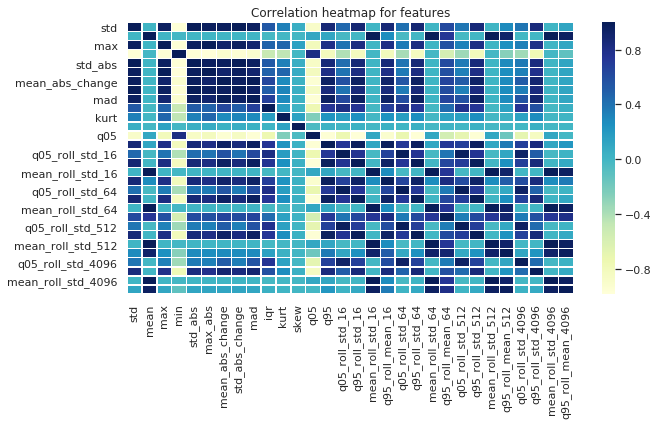

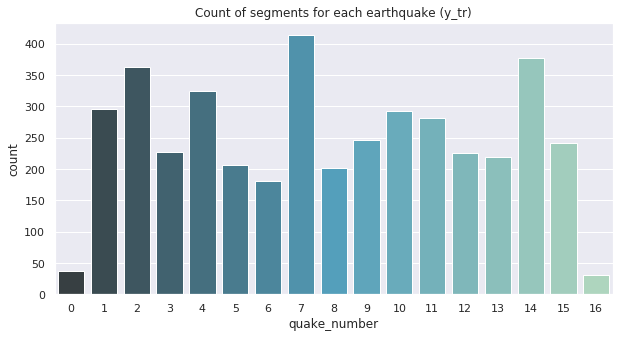

In [5]:
plt.figure(figsize=(10, 5))
plt.title("Correlation heatmap for features")
ax = sns.heatmap(X_tr.corr(), annot=False, linewidths=.3, cmap="YlGnBu")
plt.figure(figsize=(10, 5))
plt.title("Count of segments for each earthquake (y_tr)")
ax = sns.countplot(x="quake_number", data=y_tr, palette='GnBu_d')

Let's also remove the first and last group; so we have 15 groups.

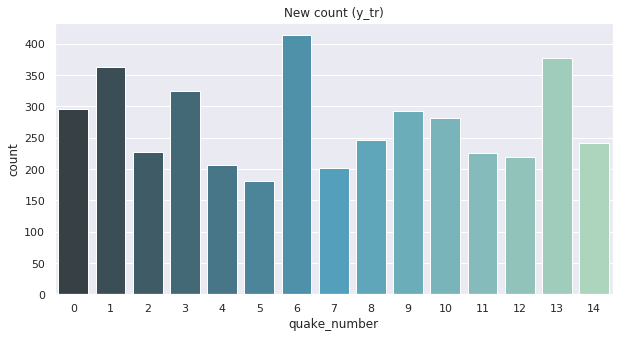

In [6]:
keep_idx = y_tr[(y_tr.quake_number > 0) & (y_tr.quake_number < 16)].index
X_tr, y_tr = X_tr.iloc[keep_idx], y_tr.iloc[keep_idx]
y_tr.quake_number = y_tr.quake_number - 1  # start counting at 0
plt.figure(figsize=(10, 5))
plt.title("New count (y_tr)")
ax = sns.countplot(x="quake_number", data=y_tr, palette='GnBu_d')

<h2>Predict earthquake (multiclass model)</h2>

Using a classifier with 15 possible classes:

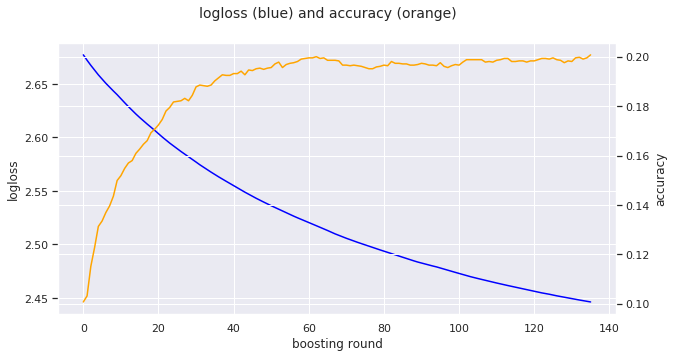

In [7]:
params = {
    'objective': 'multiclass',  # Softmax
    'metric': ['multi_logloss', 'multi_error'],
    'num_class': 15,
    "boosting": "gbdt",
    'num_leaves': 32,
    'min_data_in_leaf': 10, 
    'max_depth': -1,
    'learning_rate': 0.01,
    "feature_fraction": 1,
    "bagging_freq": 5,
    "bagging_fraction": 0.9,
    "bagging_seed": 19,
    "lambda_l2": 0.1,
    "num_boost_round": 90000,
    "verbosity": -1,
    "nthread": -1,
}
dataset = lgb.Dataset(X_tr, label=y_tr.quake_number)
result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100, stratified=False)
plot_multiclass(result)

In [17]:
params['num_boost_round'] = len(result['multi_error-mean'])
bst = lgb.train(params, dataset)
s = pd.DataFrame({'feature': X_tr.columns,
                  'gain': bst.feature_importance(importance_type='gain')})
s.sort_values(by='gain', ascending=False).head()

,feature,gain
21,q95_roll_mean_64,31458.374495
1,mean,23869.858433
22,q05_roll_std_512,21763.000724
18,q05_roll_std_64,21474.502374
26,q05_roll_std_4096,20740.235864


Trying the first 3 earthquakes only:

In [ ]:
params['num_boost_round'] = 99999
params['num_class'] = 3
idx = y_tr[(y_tr.quake_number >= 0) & (y_tr.quake_number < 3)].index
dataset = lgb.Dataset(X_tr.iloc[idx], label=y_tr.loc[idx, 'quake_number'])
result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100, stratified=False)
plot_multiclass(result)

<h2>Binary prediction</h2>

We can also try a binary classification model with only two earthquakes. In this case, the results are very different depending on the quakes we are comparing:

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    "boosting": "gbdt",
    'num_leaves': 22,
    'min_data_in_leaf': 10, 
    'max_depth': -1,
    'learning_rate': 0.01,
    "feature_fraction": 1,
    "bagging_freq": 5,
    "bagging_fraction": 0.9,
    "bagging_seed": 19,
    "lambda_l2": 0.05,
    "num_boost_round": 90000,
    "verbosity": -1,
    "nthread": -1,
}
# Predict if a segment came from group A or B
def binary_prediction(q1, q2):
    assert(q1 < q2)
    idx = y_tr[(y_tr.quake_number == q1) | (y_tr.quake_number == q2)].index
    binary_target = y_tr.loc[idx, 'quake_number'] > q1
    dataset = lgb.Dataset(X_tr.iloc[idx], label=binary_target)
    result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100, stratified=True)
    num_rounds = len(result['auc-mean'])

    plt.figure(figsize=(10, 5))
    plt.title("AUC - earthquake {} vs {}".format(q1, q2))
    ax = sns.lineplot(x=np.arange(num_rounds), y=result['auc-mean'])

In [ ]:
binary_prediction(2, 3)

In [ ]:
binary_prediction(2, 11)

In [ ]:
binary_prediction(1, 6)

<h2>Predict TTF > 12</h2>

Most of the error is coming from long earthquake cycles, we can try a classifier to distinguish between long and short cycles.

In [ ]:
binary_target = (y_tr.time_to_failure > 12).astype('int8')
binary_target.value_counts()

In [ ]:
f = X_tr.columns
dataset = lgb.Dataset(X_tr[f], label=binary_target)
result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100,
                stratified=False, shuffle=True)
num_rounds = len(result['auc-mean'])

plt.figure(figsize=(10, 5))
plt.title("AUC - predicting TTF > 12")
ax = sns.lineplot(x=np.arange(num_rounds), y=result['auc-mean'])

With only two features:

In [ ]:
f = ['q05_roll_std_64', 'q95_roll_mean_64']
dataset = lgb.Dataset(X_tr[f], label=binary_target)
result = lgb.cv(params, dataset, nfold=10, early_stopping_rounds=100,
                stratified=False, shuffle=True)
num_rounds = len(result['auc-mean'])

plt.figure(figsize=(10, 5))
plt.title("AUC - predicting TTF > 12")
ax = sns.lineplot(x=np.arange(num_rounds), y=result['auc-mean'])